In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from Transformer import *
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df = pd.read_csv("power_usage.csv", usecols=["power"])


power_usage = df.to_numpy().flatten()

for i in range(len(power_usage)):
    power_usage[i] = int(np.clip(math.ceil(power_usage[i] / 1000 + 100), 0,  300_000 / 1000 + 3))

# Visualizations from Energy Predictor

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"


num_head = 16
num_encoder_layers = 8
num_decoder_layers = 8
num_tokens = int(300_000 / 1000 + 3)
seq_length = 40

energy_model = Transformer(num_tokens=num_tokens, dim_model=256, num_heads=num_head, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout=0.2)
energy_model.load_state_dict(torch.load('../models/transformer_energy_predictor.pth'))
energy_model.to(device)

Transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (embedding): Embedding(303, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDy

In [24]:
random_start_location = random.randint(0, len(power_usage) - seq_length - 30) # This will be fed into the energy predictor, so only needs 40 sequence values
predicted_energy_usage = transformer_predict(energy_model, torch.tensor(np.array([power_usage[random_start_location:random_start_location+seq_length]]), dtype=torch.long, device=device), device=device)
predicted_energy_usage = predicted_energy_usage[1:-1]
predicted_energy_usage = predicted_energy_usage[:40]


Text(0.5, 0.98, 'Four Predictions of Energy Usage')

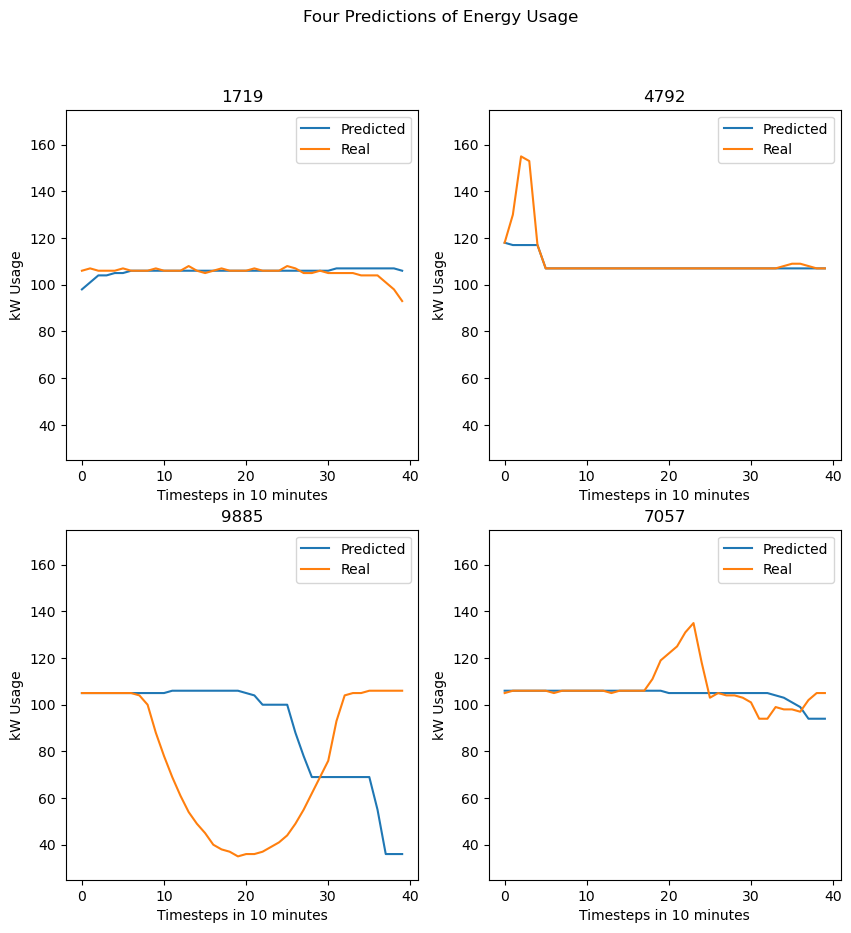

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        random_start_location = random.randint(0, len(power_usage) - seq_length - 30) # This will be fed into the energy predictor, so only needs 40 sequence values
        predicted_energy_usage = np.array(transformer_predict(energy_model, torch.tensor(np.array([power_usage[random_start_location:random_start_location+seq_length]]), dtype=torch.long, device=device), device=device))
        # predicted_energy_usage -= 100
        predicted_energy_usage = predicted_energy_usage[1:-1]
        predicted_energy_usage = predicted_energy_usage[:40]

        ax[i][j].plot(predicted_energy_usage, label="Predicted")
        ax[i][j].plot(np.array(power_usage[random_start_location:random_start_location+seq_length]), label="Real")
        ax[i][j].set_xlabel("Timesteps in 10 minutes")
        ax[i][j].set_ylabel("kW Usage")
        ax[i][j].set_ylim(25, 175)
        ax[i][j].legend()
        ax[i][j].set_title(random_start_location)

fig.suptitle("Four Predictions of Energy Usage")

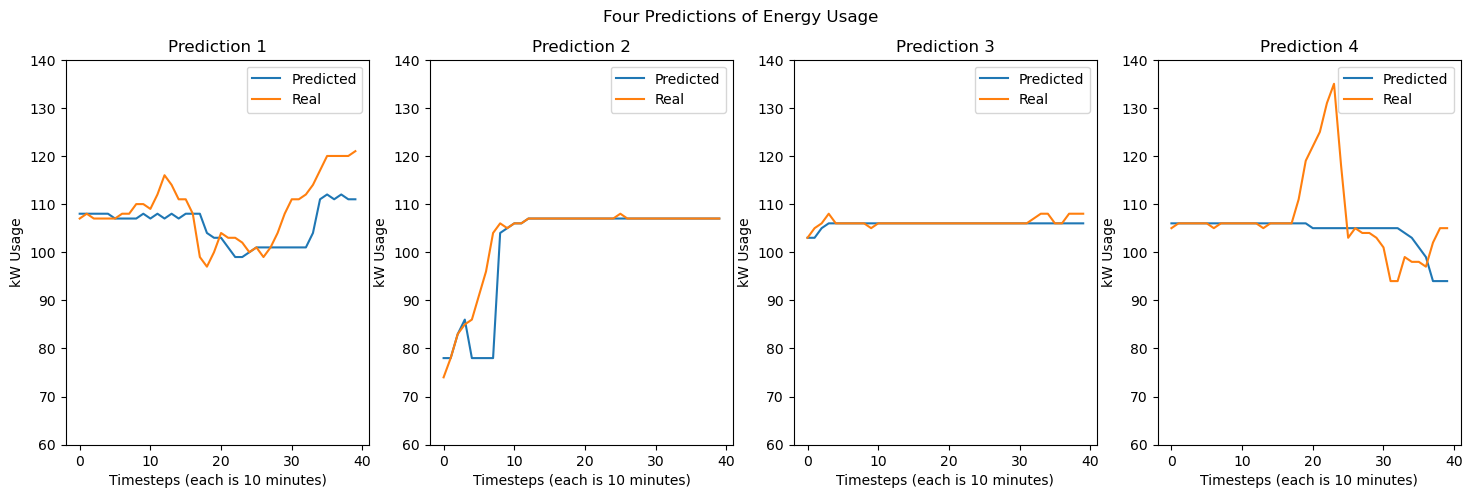

In [81]:
# Rather interesting examples I want to show from graphing a bunch of the examples so far

# 2463
# 15308
# 9515
# 7057

fig, ax = plt.subplots(1, 4, figsize=(18, 5))
random_start_locations = [2463, 15308, 9515, 7057]

i = 0
j = 0
for pred_num, random_start_location in enumerate(random_start_locations):
    predicted_energy_usage = np.array(transformer_predict(energy_model, torch.tensor(np.array([power_usage[random_start_location:random_start_location+seq_length]]), dtype=torch.long, device=device), device=device))
    # predicted_energy_usage -= 100
    predicted_energy_usage = predicted_energy_usage[1:-1]
    predicted_energy_usage = predicted_energy_usage[:40]

    ax[j].plot(predicted_energy_usage, label="Predicted")
    ax[j].plot(np.array(power_usage[random_start_location:random_start_location+seq_length]), label="Real")
    ax[j].set_xlabel("Timesteps (each is 10 minutes)")
    ax[j].set_ylabel("kW Usage")
    ax[j].set_ylim(60, 140)
    ax[j].legend()
    ax[j].set_title(f"Prediction {pred_num + 1}")

    if j < 3:
        j += 1
    else: 
        i += 1
        j = 0

    fig.suptitle("Four Predictions of Energy Usage")
plt.savefig("energy_predictions.png")
plt.show()
